<a href="https://colab.research.google.com/github/haribharadwaj/notebooks/blob/main/BME511/FilterDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filter Design

This notebook illustrates the "window" method of filter design. MATLAB's `fir1` and `fir2` both use this method and in practice you would use
one of those to design filters if you are using MATLAB. Here, we will use one of the submodules of `scipy` called `signal`, which has a function called  `firwin` which implements the window method. You would probably never do window method design by hand like done below, but this illustrates many principles and helps us take home a few thumb rules:
- The longer the filter, the sharper the cutoff in frequency domain
- All causal FIR filters that are symmetric will have some group delay

We will use a simple EKG recording to explore the effects of different design choices.

In [ ]:
import numpy as np
import pylab as pl

In [ ]:
from scipy import io
from google.colab import drive

drive.mount('/content/gdrive/')
datadir = '/content/gdrive/My Drive/BME511Data/'
datdict = io.loadmat(datadir + 'ecg.mat', squeeze_me=True)

Mounted at /content/gdrive/


In [ ]:
fs = datdict['fs']
ecg = datdict['ecg']

Text(0.5, 0, 'Time (s)')

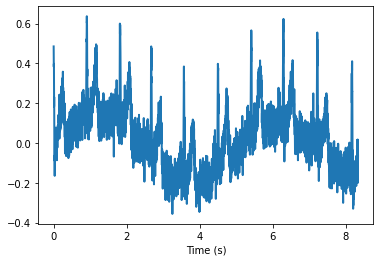

In [ ]:
t = np.arange(0, ecg.shape[0]) * 1/fs
pl.plot(t, ecg, linewidth=2)
pl.xlabel('Time (s)')

## The window method

First let's construct a filter using the window method by hand, then let's replicate that using one the pre-existing functions. 

With EKG, we want a bandpass filter in the 1 -- 40 Hz range, but let's start with lowpass and then add the highpass part to make it bandpass.

### Choice of filter length

As we discussed, the choice of the filter length is going to decide the steepness of the filter cutoff in the frequency domain.

Let's set that to `N = 256`. With a 500 Hz sampling rate, that's about 512 ms, which means our cutoff transition will be about 2 Hz wide (i.e., 1/0.512 to be exact).

So we'll start with the ideal filter shape in the Fourier domain, then IFFT to get the corresponding filter coefficients (i.e., the impulse response).

Text(0.5, 0, 'Frequency (Hz)')

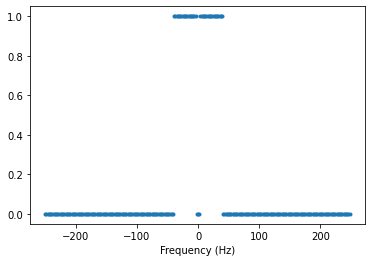

In [ ]:
N = 256
f = np.fft.fftfreq(N) * fs  # Frequency axis in Hz

# Lowpass first
H = np.zeros(N)
f_low = 40  # Lowpass cutoff, in Hz
H[np.abs(f) < f_low] = 1

# Add option highpass, making it bandpass
highpass = True
if highpass:
    f_high = 2
    H[np.abs(f) < f_high] = 0

pl.plot(f, np.abs(H), '.')
pl.xlabel('Frequency (Hz)')

## Adding group delay to make filter causal

This can be done by adding a phase that is proportional to the frequency

In [ ]:
H = H * np.exp(-2j * np.pi * f * N/(2*fs))

Text(0.5, 0, 'Time (s)')

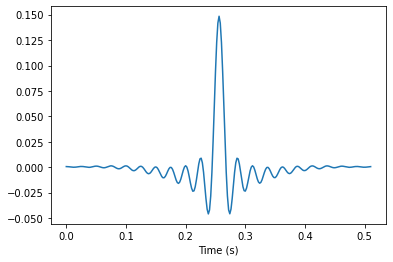

In [ ]:
h = np.fft.ifft(H).real  # We know that the imaginary part will be zero because Fourier transform is symmetric
h = h * np.hamming(N)
t_h = np.arange(0, N) / fs
pl.plot(t_h, h)
pl.xlabel('Time (s)')

## Apply filter to EKG signal

This is essentially a convolution, which can be readily computed given that the filter is FIR. However, we will use a more general filtering function called `lfilter` in `scipy.signal` because that can do both FIR and IIR filters.

Text(0.5, 0, 'Time (s)')

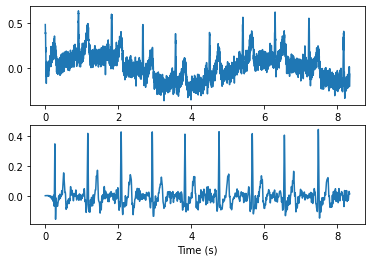

In [ ]:
from scipy import signal

ecg_filt = signal.lfilter(h, 1, ecg)
ax1 = pl.subplot(211)
ax1.plot(t, ecg)
ax2 = pl.subplot(212, sharex=ax1)
ax2.plot(t, ecg_filt)
pl.xlabel('Time (s)')

## Replicate window method using pre-existing function

This is what one would do in practice.

Text(0.5, 0, 'Time (s)')

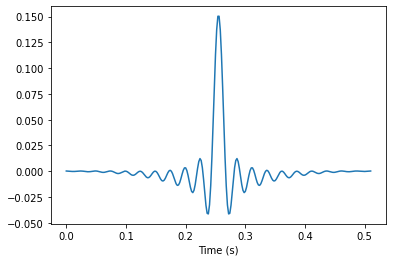

In [ ]:
h_firwin = signal.firwin(N, [f_high, f_low], pass_zero='bandpass', fs=fs)
pl.plot(t_h, h_firwin)
pl.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

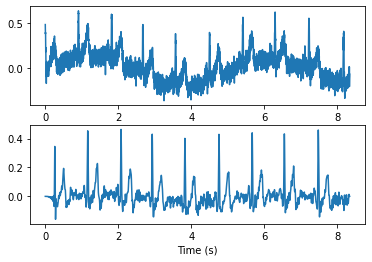

In [ ]:
ecg_filt_firwin = signal.lfilter(h_firwin, 1, ecg)
ax1 = pl.subplot(211)
ax1.plot(t, ecg)
ax2 = pl.subplot(212, sharex=ax1)
ax2.plot(t, ecg_filt_firwin)
pl.xlabel('Time (s)')

## Non-causal forward-backward filtering

By filtering the signal twice, once forward and once time-reveresed, the group delay can be eliminated. However, this makes the filter non-causal, and so cannot be done in real time. This is also squares the magnitude response.

Text(0.5, 0, 'Time (s)')

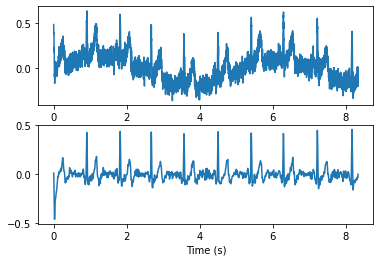

In [ ]:
ecg_filt_nodelay = signal.filtfilt(h_firwin, 1, ecg)
ax1 = pl.subplot(211)
ax1.plot(t, ecg)
ax2 = pl.subplot(212, sharex=ax1)
ax2.plot(t, ecg_filt_nodelay)
pl.xlabel('Time (s)')